# Whole brian analysis




# ROI analysis

1. Define ROI:
- Execute F-test analysis(cos(6*theta) + sin(6*theta)) across 6 run for each subject —> con_sin.nii, con_cos.nii, Ftest.nii
- Zscore the F-test result
- Define ROI: find the peak voxel in prior EC ROI in Ftest result for each subject, and use it as seed point to generate a 5 mm sphere ROI

2. Estimate mean orientation from two training dataset:
- Execute F-test analysis of different i-fold for two training dataset —> con_sin.nii, con_cos.nii, Ftest.nii
- Masking cmap: use a 2mm whole-brain mask to exclude the signal out of the brain
- Estimate mean orientation of target ROI from step-1

3. Test the hexagonal modulation effect of different fold for test sets
- 1st_level alignPhi analysis
- Zscore the contrast map
- 2nd_level group analysis

4. Plot the specificity of 6 fold effect

# Game2 analysis

### Mean orientation change
##### Method1:

1. Estimate mean orientation from game 1
- Execute F-test analysis(cos(6*theta) + sin(6*theta)) across 6 run for each subject —> con_sin.nii, con_cos.nii, Ftest.nii
- Masking cmap: use a 2mm whole-brain mask to exclude the signal out of the brain for those contrast images
- Define ROI: find the peak voxel in prior EC ROI in Ftest result for each subject, and use it as seed point to generate a 5 mm sphere ROI
- Estimate mean orientation of target ROI based on the masked_con_sin.nii and masked_con_cos.nii

2. Generate game2's event files
- using the mean orientation from game1 to generate the game2's event files

3. Detect game2's hexagonal modulation effect in alignment of game1's mean orientation
- 1st_level alignPhi analysis
- 2nd_level group analysis

##### Method2:
1. Estimate mean orientation from game 1
- 1st Level analysis across 6 run for each subject —> con_sin.nii, con_cos.nii, Ftest.nii
- masking cmap: use a 2mm whole-brain mask to exclude the signal out of the brain for those contrast images
- define ROI: find the peak voxel in prior EC ROI in Ftest result for each subject, and use it as seed point to generate a 5 mm sphere ROI
- estimate mean orientation of target ROI based on the masked_con_sin.nii and masked_con_cos.nii

2. Estimate mean orientation from game 2
- 1st Level analysis across 2 run for each subject —> con_sin.nii, con_cos.nii, Ftest.nii
- masking cmap: use a 2mm whole-brain mask to exclude the signal out of the brain for those contrast images
- define ROI: find the peak voxel in prior EC ROI in Ftest result for each subject, and use it as seed point to generate a 5 mm sphere ROI
- estimate mean orientation of target ROI based on the masked_con_sin.nii and masked_con_cos.nii

3. Compare the difference between the two mean orientations estimated from game1 and game2

### RSA

In [1]:
# -*- coding: utf-8 -*-
"""

@author: QYK
"""
import os
import numpy as np
import pandas as pd
from os.path import join
from nilearn.image import math_img, load_img,resample_to_img
from nilearn.masking import apply_mask
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix


def load_ev_separate(event_path):
    event = pd.read_csv(event_path,sep='\t')
    event_condition = event.query("trial_type in ['M1','M2_corr','M2_error','decision_corr','decision_error','pressButton']")
    pmod_cos = event.query("trial_type =='cos'")
    pmod_sin = event.query("trial_type =='sin'")

    # generate parametric modulation for M2
    m2_corrxcos = pmod_cos.copy()
    m2_corrxcos['trial_type'] = 'M2_corrxcos'

    m2_corrxsin = pmod_sin.copy()
    m2_corrxsin['trial_type'] = 'M2_corrxsin'

    # generate parametric modulation for decision
    cos_mod = pmod_cos['modulation'].to_list()
    sin_mod = pmod_sin['modulation'].to_list()

    decision_corrxcos = event.query("trial_type == 'decision_corr'")
    decision_corrxsin = decision_corrxcos.copy()

    decision_corrxcos = decision_corrxcos.replace('decision_corr','decision_corrxcos')
    decision_corrxsin = decision_corrxsin.replace('decision_corr','decision_corrxsin')

    decision_corrxcos.loc[:,'modulation'] = cos_mod
    decision_corrxsin.loc[:,'modulation'] = sin_mod

    event_condition = event_condition.append([m2_corrxcos,m2_corrxsin,decision_corrxcos,decision_corrxsin])
    event_condition = event_condition[['onset', 'duration', 'trial_type', 'modulation']]
    return event_condition


def prepare_data(subj,run_list,ifold,configs):
    """prepare images and design matrixs from different run """

    tr = configs['TR']
    func_dir = configs['func_dir']
    event_dir = configs['event_dir']

    task = configs['task']
    glm_type = configs['glm_type']

    func_name = configs['func_name']
    events_name = configs['events_name']
    regressor_file = configs['regressor_name']
    ifold = '{}fold'.format(ifold)

    functional_imgs = []
    design_matrices = []
    for i,run_id in enumerate(run_list):
        # load image
        func_path = join(func_dir,f'sub-{subj}','func',func_name.format(subj,run_id))
        func_img = load_img(func_path)
        functional_imgs.append(func_img)

        # load event
        event_path = join(event_dir,f'sub-{subj}',task,glm_type,ifold,events_name.format(subj,run_id))
        event = load_ev_separate(event_path)

        # load motion
        add_reg_names =  ['trans_x', 'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2',
                          'trans_y', 'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2',
                          'trans_z', 'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2',
                          'rot_x', 'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2',
                          'rot_y', 'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
                          'rot_z', 'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2']
        confound_file = os.path.join(func_dir,f'sub-{subj}', 'func',regressor_file.format(subj,run_id))
        confound_factors = pd.read_csv(confound_file,sep="\t")
        motion = confound_factors[add_reg_names]
        motion = motion.fillna(0.0)

        # creat design matrix
        n_scans = func_img.shape[-1]
        frame_times = np.arange(n_scans) * tr
        high_pass_fre = 1/128
        design_matrix = make_first_level_design_matrix(
            frame_times,
            event,
            hrf_model='spm',
            drift_model=None,
            high_pass=high_pass_fre,add_regs=motion,add_reg_names=add_reg_names)
        design_matrices.append(design_matrix)

    return functional_imgs, design_matrices


def pad_vector(contrast_, n_columns):
    """A small routine to append zeros in contrast vectors"""
    return np.hstack((contrast_, np.zeros(n_columns - len(contrast_))))

run_list = [1,2,3,4,5,6]
run_list = [1]
ifold = 6
configs = {'TR':3.0, 'task':'game1', 'glm_type':'separate_hexagon',
           'func_dir': r'/mnt/workdir/DCM/BIDS/derivatives/fmriprep_volume_ica',
           'event_dir': r'/mnt/workdir/DCM/BIDS/derivatives/Events',
           'func_name': r'sub-{}_task-game1_run-{}_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
           'events_name':r'sub-{}_task-game1_run-{}_events.tsv',
           'regressor_name':r'sub-{}_task-game1_run-{}_desc-confounds_timeseries.tsv'}

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game1_fmri==1')
pid = data['Participant_ID'].to_list()
subjects = [p.split('_')[-1] for p in pid]
subjects = ['010']

for subj in subjects:
    datasink = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/{}/{}/Setall/{}fold/sub-{}'.format(configs['task'],configs['glm_type'],ifold,subj)
    functional_imgs, design_matrices = prepare_data(subj,run_list,ifold,configs)

    # fit first level glm to estimate mean orientation
    mni_mask = r'/mnt/data/Template/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-02_desc-brain_mask.nii'
    # define contrast
    contrast_matrix = np.eye(design_matrices[0].shape[1])
    basic_contrasts = dict([(column, contrast_matrix[i])
                            for i, column in enumerate(design_matrices[0].columns)])

    contrasts = {'m2_cos':basic_contrasts['M2_corrxcos'],
                 'm2_sin':basic_contrasts['M2_corrxsin'],
                 'decision_cos':basic_contrasts['decision_corrxcos'],
                 'decision_sin':basic_contrasts['decision_corrxsin'],
                 'm2':basic_contrasts['M2_corr'],
                 'decision':basic_contrasts['decision_corr']}

    contrasts['cos'] = contrasts['m2_cos'] + contrasts['decision_cos']
    contrasts['sin'] = contrasts['m2_sin'] + contrasts['decision_sin']

    contrasts['m2_hexagon'] = np.vstack([contrasts['m2_cos'],contrasts['m2_sin']])
    contrasts['decision_hexagon'] = np.vstack([contrasts['decision_cos'],contrasts['decision_sin']])
    contrasts['hexagon'] = np.vstack([contrasts['cos'],contrasts['sin']])

/home/dell/.local/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


A 'modulation' column was found in the given events data and is used.


<AxesSubplot:label='conditions'>

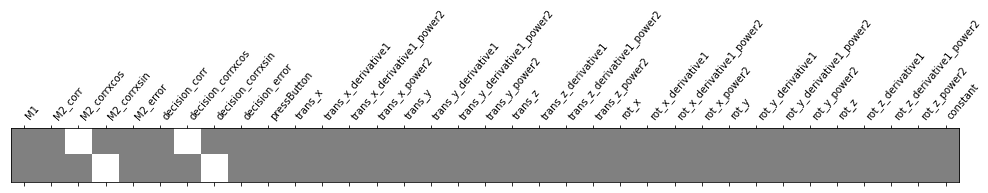

In [14]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(contrasts['hexagon'],design_matrices[0])

In [2]:
design_matrices[0]

,M1,M2_corr,M2_corrxcos,M2_corrxsin,M2_error,decision_corr,decision_corrxcos,decision_corrxsin,decision_error,pressButton,...,rot_x_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,rot_z_derivative1,rot_z_derivative1_power2,rot_z_power2,constant
0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.808137e-06,0.000497,0.000000,0.000000e+00,2.475003e-07,-0.000586,0.000000,0.000000e+00,3.429098e-07,1.0
3.0,0.004022,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.196114e-06,0.000290,-0.000208,4.325110e-08,8.382473e-08,-0.000530,0.000056,3.093584e-09,2.808629e-07,1.0
6.0,0.324819,0.015670,-0.005516,1.466669e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.941087e-07,0.000313,0.000023,5.322249e-10,9.771563e-08,-0.000450,0.000080,6.352090e-09,2.027386e-07,1.0
9.0,0.459800,0.394933,-0.139016,3.696573e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.343698e-06,0.000664,0.000352,1.237520e-07,4.413995e-07,-0.000532,-0.000082,6.712033e-09,2.832283e-07,1.0
12.0,0.165209,0.405400,-0.142701,3.794548e-01,0.000000,0.004903,-0.001726,0.004590,0.000000,0.000891,...,1.045506e-06,0.000536,-0.000128,1.639783e-08,2.876445e-07,-0.000450,0.000082,6.712033e-09,2.027386e-07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483.0,-0.008235,0.057346,0.081788,1.692165e-02,-0.000161,0.354005,0.375485,0.014870,-0.001647,0.010826,...,1.009703e-04,-0.003214,0.000242,5.840439e-08,1.033140e-05,0.006532,0.000345,1.191838e-07,4.266363e-05,1.0
486.0,0.358515,-0.009218,-0.053053,6.142504e-03,0.000000,0.185614,0.197274,0.008073,-0.000392,0.003877,...,1.058985e-04,-0.003335,-0.000121,1.463616e-08,1.112376e-05,0.006350,-0.000182,3.295677e-08,4.032504e-05,1.0
489.0,0.431188,0.383342,-0.475544,1.765871e-03,0.000000,0.026418,0.030719,0.003117,0.000000,-0.000020,...,1.022748e-04,-0.003304,0.000031,9.746884e-10,1.091648e-05,0.006399,0.000048,2.345465e-09,4.094247e-05,1.0
492.0,0.135396,0.364089,-0.423556,4.223521e-04,0.000000,0.169600,-0.224834,0.000938,0.000000,0.009064,...,1.137593e-04,-0.003471,-0.000167,2.774223e-08,1.204486e-05,0.006349,-0.000050,2.476058e-09,4.030815e-05,1.0


<AxesSubplot:label='conditions', ylabel='scan number'>

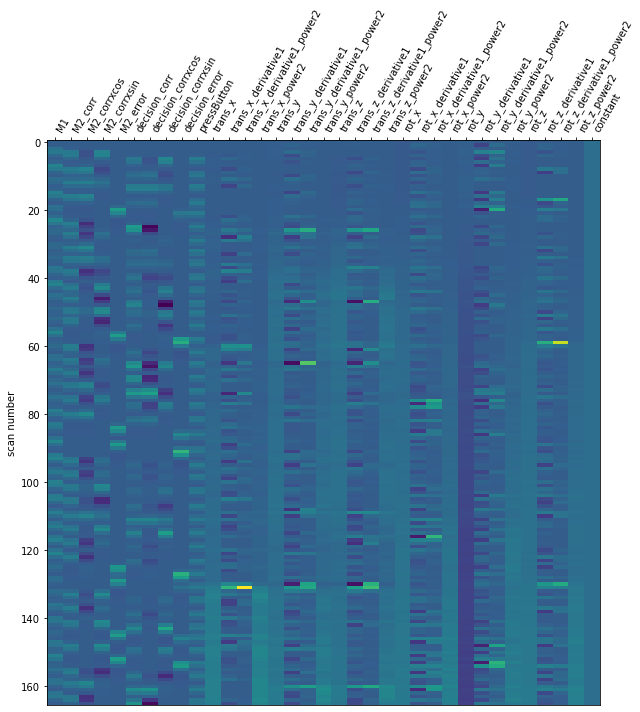

In [4]:
from nilearn.plotting import plot_design_matrix

plot_design_matrix(design_matrices[0])